# Introduction and Overview

This notebook will explore using Python, pandas and scikit-learn to perform data analysis, cleanup and prediction.

Scikit-learn contains a dataset of house prices in the Boston area, which is what we will be using for our analysis today. The documentation for this dataset can be accessed [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html). The dataset containes 13 features and 1 target for 506 suburbs surrounding Boston (one row per suburb).

Using this dataset, we will create a model to predict the median value of a home in a give community based on the 13 features given.

As our first step we will import the libraries we are using:

In [1]:
# Data manipulation libraries
import pandas as pd
# Machine Learning libraries
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
# Plotting library
import matplotlib.pyplot as plt
import seaborn as sns # Standard convention and West Wing joke

# Loading and Labeling Data

Next, I will load the data and place the it into a pandas DataFrame for easier manipulation. We will use the feature_names attribute to name the columns appropriately and add in the target values, the median price of a home in that community. (MEDV)

In [2]:
boston_data = load_boston() # load
boston = pd.DataFrame(boston_data.data) # to DataFrame
boston.columns = boston_data.feature_names # add feature labels
boston['MEDV']=pd.Series(boston_data.target) # add target values
boston.head(5) # display data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Uncomment and access the DESCR attribute to see an overview of the data and a description of the features.

In [3]:
#print(boston_data.DESCR)

# Exploratory Data Analysis

I will check the minimum and maximum of the target (MEDV) to find the range of the data, then I will count unique target values to see the relative distribution of the targets. 

In [4]:
boston['MEDV'].min()

5.0

In [5]:
boston['MEDV'].max()

50.0

In [6]:
boston['MEDV'].value_counts(sort=True)

50.0    16
25.0     8
23.1     7
21.7     7
22.0     7
        ..
12.8     1
29.9     1
9.6      1
36.1     1
13.0     1
Name: MEDV, Length: 229, dtype: int64

It seems very strange that there is a large jump from 25 to 50, and that there are 16 values (twice more than any other specific value) that sit at exactly 50.0. These values were likely either cutoff or there was a maximum value established for the dataset. In order to provide the most accurate predictive model, we will drop the rows that have a target of exactly 50.0 as outliers.

In [7]:
boston = boston[boston['MEDV']!=50.0]

Now that we've cleaned up the data, we can use the .info() method to determine if there are any missing values.

In [8]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     490 non-null    float64
 1   ZN       490 non-null    float64
 2   INDUS    490 non-null    float64
 3   CHAS     490 non-null    float64
 4   NOX      490 non-null    float64
 5   RM       490 non-null    float64
 6   AGE      490 non-null    float64
 7   DIS      490 non-null    float64
 8   RAD      490 non-null    float64
 9   TAX      490 non-null    float64
 10  PTRATIO  490 non-null    float64
 11  B        490 non-null    float64
 12  LSTAT    490 non-null    float64
 13  MEDV     490 non-null    float64
dtypes: float64(14)
memory usage: 57.4 KB


With 490 entries and 490 values in each column, we don't have any missing data.

We can plot a heatmap using the Seaborn library to examine the relationship between the independent variables. In the plot below, a value closer to 1 means that the two features are positively correlated, and a value closer to -1 means they are negatively correlated. A value near 0 indicates they are close to uncorrelated.

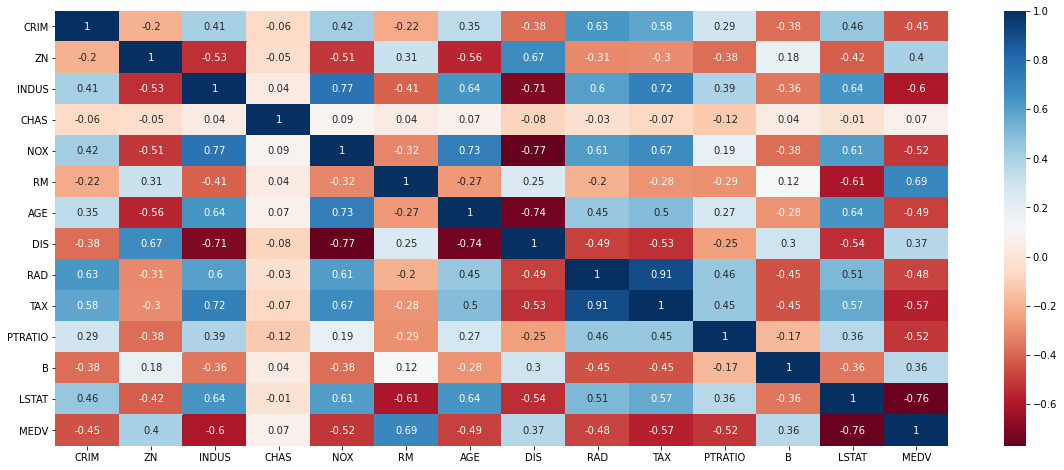

In [9]:
plt.figure(figsize=(20, 8))
matrix = boston.corr().round(2)
sns.heatmap(matrix,annot=True,cmap='RdBu')

Upon examination of the results we can see that RAD and TAX, two independent variables, are very positively correlated to one another (0.91).

In addition, LSTAT (% lower socioeconomic status of population, -0.76) and RM (average number of rooms per dwelling, 0.69) each have relatively large values of correlation with our dependent variable (MEDV). This intuitively makes sense, as a lower socioeconomic status neighborhood is often correlated with lower home values, while a higher number of rooms tends to be correlated with a higher home value.

# Splitting into Train and Test Sets

Now that we've cleaned and explored our data, it is time to split it into training and test sets. We will utilize a method included with scikit-learn known as train_test_split. We pass the features, the target variable (MEDV) and a randomly selected state variable (this enables reproducible results) to the function.

In [10]:
target = boston['MEDV']
features = boston.drop('MEDV', axis=1)
x_train , x_test, y_train, y_test = train_test_split(features, target, random_state=14)

# Selecting the Model and Performance Metrics

Now that we've split our data, we will now select a model and how we will measure the performance of the model. For our initial attempt I've chosen to use a Decision Tree Regressor algorithm. Since we are not passing a decision criterion to the function it is defaulting to selecting for splits using mean squared error.

To measure the performance of the model I have elected to use two measures of accuracy, generally looking for a minimum mean squared error and the higher Coefficient of Determination (R<sup>2</sup>). Since the regression algorithm is selecting splits based on mean squared error, we hope to find that the predicionts based on the test data will also lead to a low mean squared error.

# Training the Model

Having selected the model and performance metrics it is time to train the model.

In order to explore the effects of altering the `max_depth` hyperparameter we are creating four instances of the model, all with a different value of `max_depth`. This hyperparameter determines the maximum number of levels that the decision tree will split before stopping the training process.

In [11]:
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_1.fit(x_train,y_train)

regr_2 = DecisionTreeRegressor(max_depth=5)
regr_2.fit(x_train,y_train)

regr_3 = DecisionTreeRegressor(max_depth=10)
regr_3.fit(x_train,y_train)

regr_4 = DecisionTreeRegressor() # max_depth = None by default
regr_4.fit(x_train,y_train)

DecisionTreeRegressor()

Following up on the training of the model, I will now run the same training data back through the model. I would expect the model to do well with the "prediction", since this was the exact information it was trained on. 

In [12]:
y4_train_predict = regr_4.predict(x_train)
print('Mean squared error (y2): %.2f'
      % mean_squared_error(y_train, y4_train_predict))
print('Coefficient of determination (y2): %.2f'
      % r2_score(y_train, y4_train_predict))

Mean squared error (y2): 0.00
Coefficient of determination (y2): 1.00


It does in fact do very well, 100% accurately predicting the price of the homes. Using the version of the model with no `max_depth` parameter means that every single data point is its own branch, which led to the 100% prediction rate on training data.

While on the surface this may seem promising, it actually brings to the surface the concern of overfitting the model to the particular circumstances of the training set. This is one reason to consider avoiding the use of the model with no `max_depth` parameter.

Now we will predict house prices based on the features in our test split.

In [13]:
y1_predict = regr_1.predict(x_test)
y2_predict = regr_2.predict(x_test)
y3_predict = regr_3.predict(x_test)
y4_predict = regr_4.predict(x_test)

Below we plot the results of our predictions. I have chosen to plot the real value along the x-axis and the predicted value along the y-axis. For a model with perfect predictions we would see all of the points along a straight diagonal line from the lower left to the upper right (included in light blue for reference).

Text(0.5, 1.0, 'Max Depth = None')

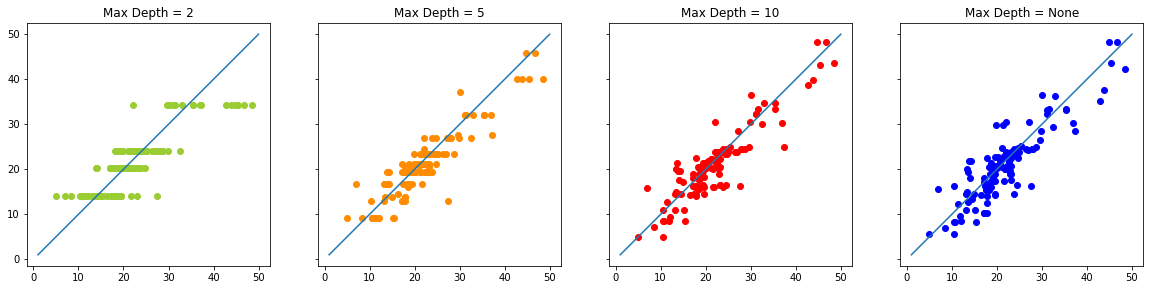

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, subplot_kw=dict(aspect=1), sharey=True, sharex=True, figsize=(20,8))

ax1.scatter(y_test,y1_predict,color="yellowgreen",label="y1")
ax1.plot([1,50],[1,50])
ax2.scatter(y_test,y2_predict,color="darkorange",label="y2")
ax2.plot([1,50],[1,50])
ax3.scatter(y_test,y3_predict,color="red",label="y3")
ax3.plot([1,50],[1,50])
ax4.scatter(y_test,y4_predict,color="blue",label="y4")
ax4.plot([1,50],[1,50])

ax1.set_title('Max Depth = 2')
ax2.set_title('Max Depth = 5')
ax3.set_title('Max Depth = 10')
ax4.set_title('Max Depth = None')

Each of the graphs has a general up and right flow. Below we will qualitatively examine the 4 graphs:

For `max_depth = 2`, notice that each of the homes has been give on of 4 prices (4 horizontal rows); this is a function of only have two levels of branches.

For `max_depth = 5`, there is still an obvious amount of horizontal lines, but it seems to be more spread out.

For `max_depth = 10` and `max_depth = None`, these models are very similar to one another, and there is very little obvious horizontal lines. This could be evidence of overfitting, or just an artifact of more layers of depth in the branches.

Let's look at the mean squared error for the four versions of the model:

In [15]:
print('Mean squared error (y1): %.2f'
      % mean_squared_error(y_test, y1_predict))
print('Mean squared error (y2): %.2f'
      % mean_squared_error(y_test, y2_predict))
print('Mean squared error (y3): %.2f'
      % mean_squared_error(y_test, y3_predict))
print('Mean squared error (y4): %.2f'
      % mean_squared_error(y_test, y4_predict))

Mean squared error (y1): 18.95
Mean squared error (y2): 11.18
Mean squared error (y3): 12.30
Mean squared error (y4): 15.53


There is little surprise after plotting the results that `max_depth = 2` was the worst performer, but I was taken aback that `max_depth = None` performed nearly as poorly. A lesson to take away is that while overfitting a model can be a problem, not allowing enough room for the model to fit the data can also lead to poor performance.

Let's look at the coefficient of determination:

In [16]:
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination (y1): %.2f'
      % r2_score(y_test, y1_predict))
print('Coefficient of determination (y2): %.2f'
      % r2_score(y_test, y2_predict))
print('Coefficient of determination (y3): %.2f'
      % r2_score(y_test, y3_predict))
print('Coefficient of determination (y4): %.2f'
      % r2_score(y_test, y4_predict))

Coefficient of determination (y1): 0.71
Coefficient of determination (y2): 0.83
Coefficient of determination (y3): 0.81
Coefficient of determination (y4): 0.76


This follows along the same lines as above, with `max_depth = 5` having the best coefficient of determination, trailed by the others in the same order.

As the final piece of our exploration in this notebook, let's see if these results hold given a different train/test split. All of the code from the above section will be repeated with only the `random_state` variable changing. I will define a function to run all of the above code, feeding in the random state as a variable

In [17]:
def regression_analysis(state_variable):
    
    x_train , x_test, y_train, y_test = train_test_split(features, target, random_state = state_variable)
    regr_1 = DecisionTreeRegressor(max_depth=2)
    regr_1.fit(x_train,y_train)

    regr_2 = DecisionTreeRegressor(max_depth=5)
    regr_2.fit(x_train,y_train)

    regr_3 = DecisionTreeRegressor(max_depth=10)
    regr_3.fit(x_train,y_train)

    regr_4 = DecisionTreeRegressor() # max_depth = None by default
    regr_4.fit(x_train,y_train)

    y1_predict = regr_1.predict(x_test)
    y2_predict = regr_2.predict(x_test)
    y3_predict = regr_3.predict(x_test)
    y4_predict = regr_4.predict(x_test)

    print('Mean squared error (y1): %.2f'
          % mean_squared_error(y_test, y1_predict))
    print('Mean squared error (y2): %.2f'
          % mean_squared_error(y_test, y2_predict))
    print('Mean squared error (y3): %.2f'
          % mean_squared_error(y_test, y3_predict))
    print('Mean squared error (y4): %.2f'
          % mean_squared_error(y_test, y4_predict))

    print('Coefficient of determination (y1): %.2f'
          % r2_score(y_test, y1_predict))
    print('Coefficient of determination (y2): %.2f'
          % r2_score(y_test, y2_predict))
    print('Coefficient of determination (y3): %.2f'
          % r2_score(y_test, y3_predict))
    print('Coefficient of determination (y4): %.2f'
          % r2_score(y_test, y4_predict))

Now let's call the function with two different `state_variable`'s

In [18]:
print("----- Random State = 22 -----")
regression_analysis(state_variable=22)
print("\n----- Random State = 1 -----")
regression_analysis(state_variable=1)

----- Random State = 22 -----
Mean squared error (y1): 18.92
Mean squared error (y2): 10.99
Mean squared error (y3): 15.07
Mean squared error (y4): 12.61
Coefficient of determination (y1): 0.61
Coefficient of determination (y2): 0.77
Coefficient of determination (y3): 0.69
Coefficient of determination (y4): 0.74

----- Random State = 1 -----
Mean squared error (y1): 18.35
Mean squared error (y2): 14.02
Mean squared error (y3): 13.82
Mean squared error (y4): 15.34
Coefficient of determination (y1): 0.67
Coefficient of determination (y2): 0.75
Coefficient of determination (y3): 0.75
Coefficient of determination (y4): 0.72


We can see from the above two examples that the train/test split definitely affects the model and how the hyperparameters should be chosen.

While we are done with our exploration for this notebook, future work on this model could include:
1. The introduction and tuning of additional hyperparameters in the DecisionTreeRegressor implementation
2. Feature selection on the underlying data
3. Additional exploration to eliminate overfitting of the model to the training set